## Interpretation of TF models trained on UniProtKB Coronaviridae S protein dataset for multiclass classification

In [45]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python310.zip',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/lib-dynload',
 '',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../..',
 '/home/grads/blessyantony/dev/git/zoon

In [46]:
from prediction.models.nlp import transformer
from src.utils import utils, nn_utils

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE



In [60]:
label_groupings = {
                    "Pig": [ "Sus scrofa (Pig) [TaxID: 9823]" ],
                    "Human": [ "Homo sapiens (Human) [TaxID: 9606]" ],
                    "Wild turkey": [ "Meleagris gallopavo (Wild turkey) [TaxID: 9103]" ],
                    "Japanese pipistrelle": [ "Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]" ],
                    "Lesser bamboo bat": [ "Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]" ],
                    "Chicken": [ "Gallus gallus (Chicken) [TaxID: 9031]" ],
                    "Bovine": [ "Bos taurus (Bovine) [TaxID: 9913]" ]
                }
# label_groupings = {"Human": [ "Homo sapiens" ],
#                   "Desert warthog": [ "Phacochoerus aethiopicus" ],
#                   "Lesser bandicoot rat": [ "Bandicota bengalensis" ],
#                   "Horse": [ "Equus caballus" ],
#                   "Goat": [ "Capra hircus" ],
#                   "Red junglefowl": [ "Gallus gallus" ],
#                   "Wood mouse": [ "Apodemus sylvaticus" ],
#                   "Cattle": [ "Bos taurus" ],
#                   "Others": [ "*" ]}

amino_acid_idx_map = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5,
                  'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
                  'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15,
                  'O': 16, 'S': 17, 'U': 18, 'T': 19, 'W': 20,
                  'Y': 21, 'V': 22, 'B': 23, 'Z': 24, 'X': 25,
                  'J': 26}
idx_amino_acid_map = {v:k for k,v in amino_acid_idx_map.items()}

train_sequence_settings =  {
    "sequence_col": "seq",
    "batch_size": 8,
    "max_sequence_length": 1453,
    "pad_sequence_val": 0,
    "truncate": True,
    "feature_type": "token"
}

test_sequence_settings =  train_sequence_settings.copy()
test_sequence_settings["batch_size"] = 1

label_settings = {
    "label_col": "virus_host",
    "exclude_labels": [ "nan"],
    "label_groupings":  label_groupings
}

model = {
    "max_seq_len": 1453,
    "loss": "CrossEntropyLoss",
    "with_convolution": False,
    "n_heads": 8,
    "depth": 6,
    "n_tokens": 27,
    "n_classes": 7,
    "n_epochs": 10,
    "input_dim": 512, # input embedding dimension
    "hidden_dim": 1024
}

### Load the datasets

In [85]:
def load_dataset(input_dir, input_file_names, sequence_settings):
    df = utils.read_dataset(input_dir, input_file_names, cols=[sequence_settings["sequence_col"], label_settings["label_col"]])
    df, index_label_map = utils.transform_labels(df, label_settings, classification_type="multi")
    dataset_loader = nn_utils.get_dataset_loader(df, sequence_settings, label_settings["label_col"])
    return index_label_map, dataset_loader

def load_dataset_with_df(df, sequence_settings):
    df = df[[sequence_settings["sequence_col"], label_settings["label_col"]]]
    df, index_label_map = utils.transform_labels(df, label_settings, classification_type="multi")
    dataset_loader = nn_utils.get_dataset_loader(df, sequence_settings, label_settings["label_col"])
    return index_label_map, dataset_loader

def print_dataset_loader(dataset_loader):
    sequence, label = next(iter(dataset_loader))
    print(sequence.shape)
    print(sequence)
    print(label.shape)
    print(label)

### Training-based interpretation
#### Encoding visualization - all viruses, all hosts

In [62]:
def compute_dataset_representations(nlp_model, dataset_loader):
    nlp_model.eval()
    seq_dfs = []
    for _, record in enumerate(dataset_loader):
        seq, label = record
        output = nlp_model(seq)
        seq_encoding = nlp_model.encoder.encoding
        # embedding = value for each dimension = mean of the dimensional values of all tokens in the input sequence
        seq_encoding = torch.mean(seq_encoding, dim=1, keepdim=True)
        seq_df = pd.DataFrame(seq_encoding.squeeze().cpu().detach().numpy())
        seq_df["label"] = label.squeeze().cpu().detach().numpy()
        seq_dfs.append(seq_df)
    df = pd.concat(seq_dfs)
    print(df.shape)
    return df


def visualize_dataset(rep_df):
    columns = rep_df.columns
    print(columns)
    X = rep_df[range(512)]
    tsne_model = TSNE(n_components=2, verbose=1, init="pca", learning_rate="auto").fit(X)
    X_emb = pd.DataFrame(tsne_model.fit_transform(X))
    print(X_emb.shape)
    print(X_emb)
    X_emb["label"] = rep_df["label"].values
    return tsne_model, X_emb
    
def visualize_prediction(nlp_model, seq, label, rep_df):
    nlp_model.eval()
    output = nlp_model(seq)
    seq_encoding = nlp_model.encoder.encoding
    seq_encoding = torch.mean(seq_encoding, dim=1, keepdim=True)

    seq_df = pd.DataFrame(seq_encoding.squeeze(1).cpu().detach().numpy())
    seq_df["label"] = label.squeeze().cpu().detach().numpy()
    sample_pred = torch.argmax(F.softmax(output, dim=1), dim=1)
    print(f"Label {label} = {index_label_map[label.item()]}")
    sample_pred_mapped = index_label_map[sample_pred.item()]
    print(f"Prediction {sample_pred}= {sample_pred_mapped}")
    seq_df["label"] = "prediction-" + sample_pred_mapped
    
    rep_df_copy = rep_df.copy()
    rep_df_copy["label"] = rep_df["label"].map(index_label_map)
    rep_df_copy = rep_df_copy[rep_df_copy["label"] != "Others"]
    X = rep_df_copy[range(512)]
    print(f"X shape = {X.shape}")
    
    tsne_model = TSNE(n_components=2, verbose=1, init="pca", learning_rate="auto").fit(X)
    X_emb = pd.DataFrame(tsne_model.fit_transform(X))
    print(f"X_emb shape = {X_emb.shape}")
    X_emb["label"] = rep_df_copy["label"].values
    print(f"X_emb shape = {X_emb.shape}")
    sns.scatterplot(data = X_emb, x=0, y=1, hue="label")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    figure_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "output/visualization/uniref90/20230713/host_multi_ismb/tf-prot-seq-embedding-pca-tsne.svg")
    plt.savefig(figure_output_filepath, format="svg")
    plt.show()

### Testing-based interpretation
#### Attention based interpretation

In [63]:
def compute_mean_attn_values(nlp_model):
    attn_values = nlp_model.encoder.layers[5].self_attn.self_attn.squeeze()
    return torch.mean(attn_values, dim=0)


def plot_mean_attention_values(x, seq=None, seq_len=None):
    ticklabels = seq.cpu().detach().numpy().squeeze()[:seq_len]
    ticklabels_mapped = [idx_amino_acid_map[x] for x in ticklabels]

    plt.rcParams['xtick.labelsize'] = 5
    plt.rcParams['ytick.labelsize'] = 5
    plt.figure(figsize=(12,12))
    data = x.cpu().detach().numpy()
    
    sns.heatmap(data=data[:seq_len, :seq_len], xticklabels=ticklabels_mapped, yticklabels=ticklabels_mapped)
    #plt.xticks(rotation=20)
    plt.show()


def plot_mean_of_mean_attention_values(x, seq=None, seq_len=None, seq_max_length=None):
    tokens = seq.cpu().detach().numpy().squeeze()
    
    x = torch.mean(x, dim=0)
    df = pd.DataFrame({"tokens": tokens, "attn_vals": x.cpu().detach().numpy(), "pos": range(seq_max_length)})
    df["tokens"] = df["tokens"].map(idx_amino_acid_map)
    df = df.dropna()
    sorted_df = df.sort_values(by="attn_vals", ascending=False).head(10)
    print("Top 10 tokens + positions with highest attention values for the whole sequence")
    print(sorted_df.head(10))
    plt.rcParams['xtick.labelsize'] = 8
    plt.rcParams['ytick.labelsize'] = 8
    plt.figure(figsize=(12,6))
    sns.scatterplot(data=df, x="pos", y="attn_vals", hue="tokens")
    plt.show()
    
def analyze_attention_of_prediction(nlp_model, sample_seq, sample_label, seq_max_length):
    # sample_seq = sample_seq.unsqueeze(0)
    seq_len= torch.count_nonzero(sample_seq)
    print(sample_seq.shape)
    print(f"seq_len = {seq_len}")
    
    nlp_model.eval()
    output = nlp_model(sample_seq)
    sample_pred = torch.argmax(F.softmax(nlp_model(sample_seq), dim=1), dim=1)
    print(f"Label = {index_label_map[sample_label.item()]}")
    print(f"Prediction = {index_label_map[sample_pred.item()]}")
    mean_attn_values = compute_mean_attn_values(nlp_model)

    plot_mean_attention_values(mean_attn_values, seq=sample_seq, seq_len=seq_len)
    plot_mean_of_mean_attention_values(mean_attn_values, seq=sample_seq, seq_len=seq_len, seq_max_length=seq_max_length)
    
def analyze_attention_of_df(nlp_model, dataset_loader, seq_max_length):
    attn_dfs = []
    max_seq_len_actual = 0
    for _, record in enumerate(dataset_loader):
        seq, label = record
        seq_len = torch.count_nonzero(seq).item()
#         if seq_len > max_seq_len_actual:
#             max_seq_len_actual = seq_len
        if seq_len < seq_max_length:
            continue
        nlp_model(seq)
        mean_attn_values = compute_mean_attn_values(nlp_model)
        mean_of_mean = torch.mean(mean_attn_values, dim=0, keepdim=True)
        attn_dfs.append(mean_of_mean.cpu().detach().numpy())
    print("max_seq_len_actual = ", max_seq_len_actual)
    attn_df = np.concatenate(attn_dfs, axis=0)
    plt.figure(figsize=(12,12))
    sns.heatmap(data=attn_df)#[:,:max_seq_len_actual])
    return attn_df

In [64]:
def get_top_10_attn_vals_df(nlp_model, dataset_loader, seq_max_length):
    seq_i = 0
    top_10_attn_vals = []
    for _, record in enumerate(dataset_loader):
        seq, label = record
        label = index_label_map[label.item()]
        
        seq_len = torch.count_nonzero(seq).item()
        pred = torch.argmax(F.softmax(nlp_model(seq), dim=1), dim=1)
        pred = index_label_map[pred.item()]
        
        mean_attn_values = compute_mean_attn_values(nlp_model)
        mean_of_mean = torch.mean(mean_attn_values, dim=0)
        
        tokens = seq.cpu().detach().numpy().squeeze()
        seq_attn_df = pd.DataFrame({"tokens": tokens,
                                    "attn_vals": mean_of_mean.cpu().detach().numpy(),
                                    "pos": range(seq_max_length)})
        seq_attn_df["tokens"] = seq_attn_df["tokens"].map(idx_amino_acid_map)
        seq_attn_df = seq_attn_df.dropna()
        seq_attn_df = seq_attn_df.sort_values(by="attn_vals", ascending=False).head(10)
        seq_attn_df["seq_number"] = seq_i
        seq_attn_df["label"] = label
        seq_attn_df["pred"] = pred
        
        top_10_attn_vals.append(seq_attn_df)
        
        seq_i += 1 
    top_10_attn_vals_df = pd.concat(top_10_attn_vals)
    return top_10_attn_vals_df
        

def get_attention_of_df(nlp_model, dataset_loader, seq_max_length):
    attn_dfs = []
    max_seq_len_actual = 0
    for _, record in enumerate(dataset_loader):
        seq, label = record
        seq_len = torch.count_nonzero(seq).item()
#         if seq_len > max_seq_len_actual:
#             max_seq_len_actual = seq_len
#        if seq_len < seq_max_length:
#            continue
        label = index_label_map[label.item()]
        pred = torch.argmax(F.softmax(nlp_model(seq), dim=1), dim=1)
        pred = index_label_map[pred.item()]
        mean_attn_values = compute_mean_attn_values(nlp_model)
        mean_of_mean = torch.mean(mean_attn_values, dim=0, keepdim=True)
        df = pd.DataFrame(mean_of_mean.cpu().detach().numpy(), columns=range(seq_max_length))
        df["label"] = label
        df["pred"] = pred
        attn_dfs.append(df)
    
    attn_df = pd.concat(attn_dfs, axis=0)

    return attn_df

 ### Analysis Pipeline

In [65]:
def analyse_model(model, train_dataset_loader, test_dataset_loader, seq, label, seq_max_length, viz_train=False, viz_test=False):
    if viz_train:
        train_rep_df = compute_dataset_representations(model, train_dataset_loader)
        visualize_prediction(model, seq, label, train_rep_df)
    if viz_test:
        test_rep_df = compute_dataset_representations(model, test_dataset_loader)
        visualize_dataset(test_rep_df)
    
    
    analyze_attention_of_prediction(model, seq, label, seq_max_length)
    
    analyze_attention_of_df(model, test_dataset_loader, seq_max_length)

#### UniProtKB Coronavirus only

In [80]:
uniprotkb_coronaviruses_df = pd.read_csv("/home/grads/blessyantony/dev/git/zoonosis/input/data/coronaviridae/coronaviridae_top_7_hosts.csv")
uniprotkb_coronaviruses_df.head()

id                                                seq  \
0  A3EX94  MTLLMCLLMSLLIFVRGCDSQFVDMSPASNTSECLESQVDAAAFSK...   
1  A3EXD0  MIRSVLVLMCSLTFIGNLTRGQSVDMGHNGTGSCLDSQVQPDYFES...   
2  P0DTC2  MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...   
3  P11223  MLVTPLLLVTLLCALCSAVLYDSSSYVYYYQSAFRPPSGWHLQGGA...   
4  P12651  MLVTPLLLVTLLCVLCSAALYDSSSYVYYYQSAFRPPNGWHLHGGA...   

                                               virus  seq_len  \
0     Bat coronavirus HKU4 (BtCoV) (BtCoV/HKU4/2004)     1352   
1     Bat coronavirus HKU5 (BtCoV) (BtCoV/HKU5/2004)     1352   
2  Severe acute respiratory syndrome coronavirus ...     1273   
3  Avian infectious bronchitis virus (strain Beau...     1162   
4  Avian infectious bronchitis virus (strain M41)...     1162   

                                          virus_host binary_label  
0  Tylonycteris pachypus (Lesser bamboo bat) (Ves...    Not Human  
1  Pipistrellus abramus (Japanese pipistrelle) (P...    Not Human  
2                 Homo sapiens (Human) [TaxID: 9606]        Human  
3              Gallus gallus (Chicken) [TaxID: 9031]    Not Human  
4              Gallus gallus (Chicken) [TaxID: 9031]    Not Human

In [81]:
uniprotkb_coronaviruses_df["virus_host"].value_counts()

Sus scrofa (Pig) [TaxID: 9823]                                                                  2620
Homo sapiens (Human) [TaxID: 9606]                                                              2400
Meleagris gallopavo (Wild turkey) [TaxID: 9103]                                                   36
Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]      19
Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]                  17
Gallus gallus (Chicken) [TaxID: 9031]                                                             13
Bos taurus (Bovine) [TaxID: 9913]                                                                 10
Name: virus_host, dtype: int64

In [82]:
uniprotkb_coronaviruses_humans_df = uniprotkb_coronaviruses_df[uniprotkb_coronaviruses_df["virus_host"] == "Homo sapiens (Human) [TaxID: 9606]"]
print(uniprotkb_coronaviruses_humans_df.shape)
uniprotkb_coronaviruses_humans_df.head()

(2400, 6)


id                                                seq  \
2   P0DTC2  MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...   
5   P15423  MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGG...   
12  P36334  MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNG...   
14  Q0ZME7  MFLIIFILPTTLAVIGDFNCTNSFINDYNKTIPRISEDVVDVSLGL...   
15  Q14EB0  MFLIIFILPTTLAVIGDFNCTNSFINDYNKTIPRISEDVVDVSLGL...   

                                                virus  seq_len  \
2   Severe acute respiratory syndrome coronavirus ...     1273   
5                  Human coronavirus 229E (HCoV-229E)     1173   
12                 Human coronavirus OC43 (HCoV-OC43)     1353   
14    Human coronavirus HKU1 (isolate N5) (HCoV-HKU1)     1351   
15    Human coronavirus HKU1 (isolate N2) (HCoV-HKU1)     1351   

                            virus_host binary_label  
2   Homo sapiens (Human) [TaxID: 9606]        Human  
5   Homo sapiens (Human) [TaxID: 9606]        Human  
12  Homo sapiens (Human) [TaxID: 9606]        Human  
14  Homo sapiens (Human) [TaxID: 9606]        Human  
15  Homo sapiens (Human) [TaxID: 9606]        Human

min seq len = 35
max seq len = 1366


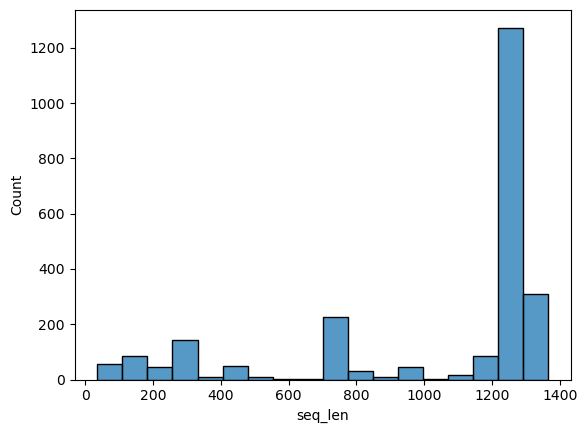

In [83]:
sns.histplot(uniprotkb_coronaviruses_humans_df["seq_len"])
print(f"min seq len = {min(uniprotkb_coronaviruses_humans_df['seq_len'])}")
print(f"max seq len = {max(uniprotkb_coronaviruses_humans_df['seq_len'])}")
plt.show()

In [86]:
index_label_map, coronavirus_dataset_loader = load_dataset_with_df(uniprotkb_coronaviruses_humans_df, test_sequence_settings)
print_dataset_loader(coronavirus_dataset_loader)
# Random seq, label from coronavirus_dataset_loader
coronavirus_seq, coronavirus_label = next(iter(coronavirus_dataset_loader))

Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
[2]
torch.Size([1, 1453])
tensor([[13, 14, 22,  ...,  0,  0,  0]], device='cuda:0')
torch.Size([1])
tensor([2], device='cuda:0')


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../../../src/utils/utils.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../../../src/utils/utils.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../../prediction/datasets/protein_sequence_dataset.py:31: Setti

### Load the trained model

#### Model: TF - PosEmb_SINCOS - MSL_1024 - d_512
#### Training Dataset: UniProtKB Coronaviridae 5K
#### Manual Seed = 0

In [87]:
model_path = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/coronaviridae/20230813/host_multi_baseline_focal/transformer-l_6-h_8_itr0.pth"
nlp_model_coronaviridae = transformer.get_transformer_model(model)
nlp_model_coronaviridae.load_state_dict(torch.load(model_path))
nlp_model_coronaviridae = nlp_model_coronaviridae.to(nn_utils.get_device())


Transformer(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(27, 512)
    (positional_embedding): PositionalEncoding()
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=512, out_features=512, bias=True)
          (W_K): Linear(in_features=512, out_features=512, bias=True)
          (W_V): Linear(in_features=512, out_features=512, bias=True)
          (W_O): Linear(in_features=512, out_features=512, bias=True)
        )
        (feed_forward): FeedForwardLayer(
          (W_1): Linear(in_features=512, out_features=1024, bias=True)
          (W_2): Linear(in_features=1024, out_features=512, bias=True)
        )
        (residual_connections): ModuleList(
          (0-1): 2 x ResidualConnectionLayer(
            (norm): NormalizationLayer()
          )
        )
      )
    )
    (norm): NormalizationLayer()
  )
  (linear): Linear(in_features=512, out_features=7, b

##### Coronaviridae S protein dataset
##### Model: TF trained on Coronaviridae S protein dataset

In [88]:
rbd_positions = [332,333,334,335,337,339,340,344,345,346,347,348,349,351,352,354,356,359,362,364,366,367,370,371,372,373,375,376,378,380,381,382,384,385,388,389,390,393,394,395,396,397,399,401,402,403,404,405,406,407,410,411,412,413,414,415,417,418,419,420,424,425,426,427,428,430,431,432,433,434,435,436,437,438,439,440,441,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,489,490,491,493,494,495,496,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,522,524]
rbm_positions = range(438, 506)

In [89]:
def analyze_top_10_attn_vals_df(nlp_model, coronavirus_dataset_loader, seq_max_length=1115):
    top_10_attn_vals_df = get_top_10_attn_vals_df(nlp_model, coronavirus_dataset_loader, seq_max_length)
    # increment the positions number by 1 since in the df it is 0-indexed
    top_10_attn_vals_df["pos"] = top_10_attn_vals_df["pos"] + 1
    print(f"top_10_attn_vals_df size = {top_10_attn_vals_df.shape}")
    
    # get the true predictions
    true_pred_coronavirus_df = top_10_attn_vals_df[top_10_attn_vals_df["label"] == top_10_attn_vals_df["pred"]]
    print(f"true_pred_coronavirus_df size = {true_pred_coronavirus_df.shape}")
    
    print(f"True prediction accuracy = {true_pred_coronavirus_df.shape[0]/top_10_attn_vals_df.shape[0] * 100}")
    
    # add a column to mark whether the position falls in the rbd domain, rbm domain
    true_pred_coronavirus_df["rbd_domain"] = true_pred_coronavirus_df["pos"].isin(rbd_positions)
    true_pred_coronavirus_df["rbm_domain"] = true_pred_coronavirus_df["pos"].isin(rbm_positions)
    
    # get number of rbd positions in each sequence
    rbd_count = true_pred_coronavirus_df[["seq_number", "pos", "rbd_domain"]].groupby(["seq_number", "rbd_domain"]).count()
    rbd_count = rbd_count.reset_index()
    print(f"Number of sequences with RBDs = {rbd_count[rbd_count['rbd_domain'] == True]['seq_number'].nunique()}")
    print(f"Average number of RBDs in sequences = {rbd_count[rbd_count['rbd_domain'] == True]['pos'].mean()}")

    # get number of rbm positions in each sequence
    rbm_count = true_pred_coronavirus_df[["seq_number", "pos", "rbm_domain"]].groupby(["seq_number", "rbm_domain"]).count()
    rbm_count = rbm_count.reset_index()
    print(f"Number of sequences with RBMs = {rbm_count[rbm_count['rbm_domain'] == True]['seq_number'].nunique()}")
    print(f"Average number of RBMs in sequences = {rbm_count[rbm_count['rbm_domain'] == True]['pos'].mean()}")

In [90]:
analyze_top_10_attn_vals_df(nlp_model_coronaviridae, coronavirus_dataset_loader, seq_max_length=1453)

top_10_attn_vals_df size = (24000, 6)
true_pred_coronavirus_df size = (12940, 6)
True prediction accuracy = 53.91666666666667
Number of sequences with RBDs = 101
Average number of RBDs in sequences = 1.0693069306930694
Number of sequences with RBMs = 15
Average number of RBMs in sequences = 1.0


/tmp/ipykernel_12246/3706710455.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_pred_coronavirus_df["rbd_domain"] = true_pred_coronavirus_df["pos"].isin(rbd_positions)
/tmp/ipykernel_12246/3706710455.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_pred_coronavirus_df["rbm_domain"] = true_pred_coronavirus_df["pos"].isin(rbm_positions)


In [91]:
attn_df = get_attention_of_df(nlp_model_coronaviridae, coronavirus_dataset_loader, seq_max_length=1453)
true_pred_attn_df = attn_df[attn_df["pred"] == attn_df["label"]]
true_pred_attn_df = true_pred_attn_df.reset_index(drop=True)
true_pred_attn_df.shape

(1294, 1455)

In [92]:
true_pred_attn_df = true_pred_attn_df.drop(columns=["label", "pred"])

In [93]:
true_pred_attn_df

0         1         2         3         4         5         6     \
0     0.000681  0.000690  0.000689  0.000691  0.000677  0.000689  0.000677   
1     0.000678  0.000688  0.000690  0.000690  0.000669  0.000691  0.000669   
2     0.000678  0.000688  0.000690  0.000690  0.000669  0.000691  0.000670   
3     0.000681  0.000690  0.000689  0.000691  0.000677  0.000689  0.000677   
4     0.000679  0.000688  0.000689  0.000691  0.000672  0.000690  0.000673   
...        ...       ...       ...       ...       ...       ...       ...   
1289  0.000681  0.000690  0.000689  0.000691  0.000677  0.000689  0.000677   
1290  0.000681  0.000689  0.000688  0.000691  0.000677  0.000689  0.000677   
1291  0.000678  0.000688  0.000690  0.000690  0.000669  0.000691  0.000670   
1292  0.000679  0.000689  0.000689  0.000691  0.000673  0.000690  0.000674   
1293  0.000678  0.000688  0.000690  0.000690  0.000669  0.000691  0.000669   

          7         8         9     ...      1443      1444      1445  \
0     0.000677  0.000680  0.000675  ...  0.000687  0.000686  0.000685   
1     0.000669  0.000672  0.000668  ...  0.000684  0.000681  0.000681   
2     0.000669  0.000672  0.000668  ...  0.000684  0.000681  0.000681   
3     0.000677  0.000680  0.000675  ...  0.000687  0.000686  0.000685   
4     0.000673  0.000676  0.000671  ...  0.000686  0.000684  0.000683   
...        ...       ...       ...  ...       ...       ...       ...   
1289  0.000677  0.000680  0.000675  ...  0.000687  0.000686  0.000685   
1290  0.000676  0.000680  0.000675  ...  0.000687  0.000686  0.000685   
1291  0.000669  0.000672  0.000668  ...  0.000684  0.000681  0.000681   
1292  0.000674  0.000677  0.000672  ...  0.000686  0.000684  0.000684   
1293  0.000669  0.000672  0.000668  ...  0.000684  0.000681  0.000681   

          1446      1447      1448      1449      1450      1451      1452  
0     0.000686  0.000688  0.000689  0.000690  0.000691  0.000691  0.000691  
1     0.000683  0.000685  0.000686  0.000688  0.000688  0.000689  0.000690  
2     0.000683  0.000685  0.000686  0.000688  0.000689  0.000689  0.000690  
3     0.000686  0.000688  0.000689  0.000690  0.000691  0.000691  0.000691  
4     0.000684  0.000686  0.000688  0.000689  0.000690  0.000690  0.000691  
...        ...       ...       ...       ...       ...       ...       ...  
1289  0.000686  0.000688  0.000689  0.000690  0.000691  0.000691  0.000691  
1290  0.000686  0.000688  0.000689  0.000690  0.000691  0.000691  0.000691  
1291  0.000683  0.000685  0.000686  0.000688  0.000689  0.000689  0.000690  
1292  0.000685  0.000686  0.000688  0.000689  0.000690  0.000691  0.000691  
1293  0.000683  0.000685  0.000686  0.000688  0.000688  0.000689  0.000690  

[1294 rows x 1453 columns]

<AxesSubplot:>

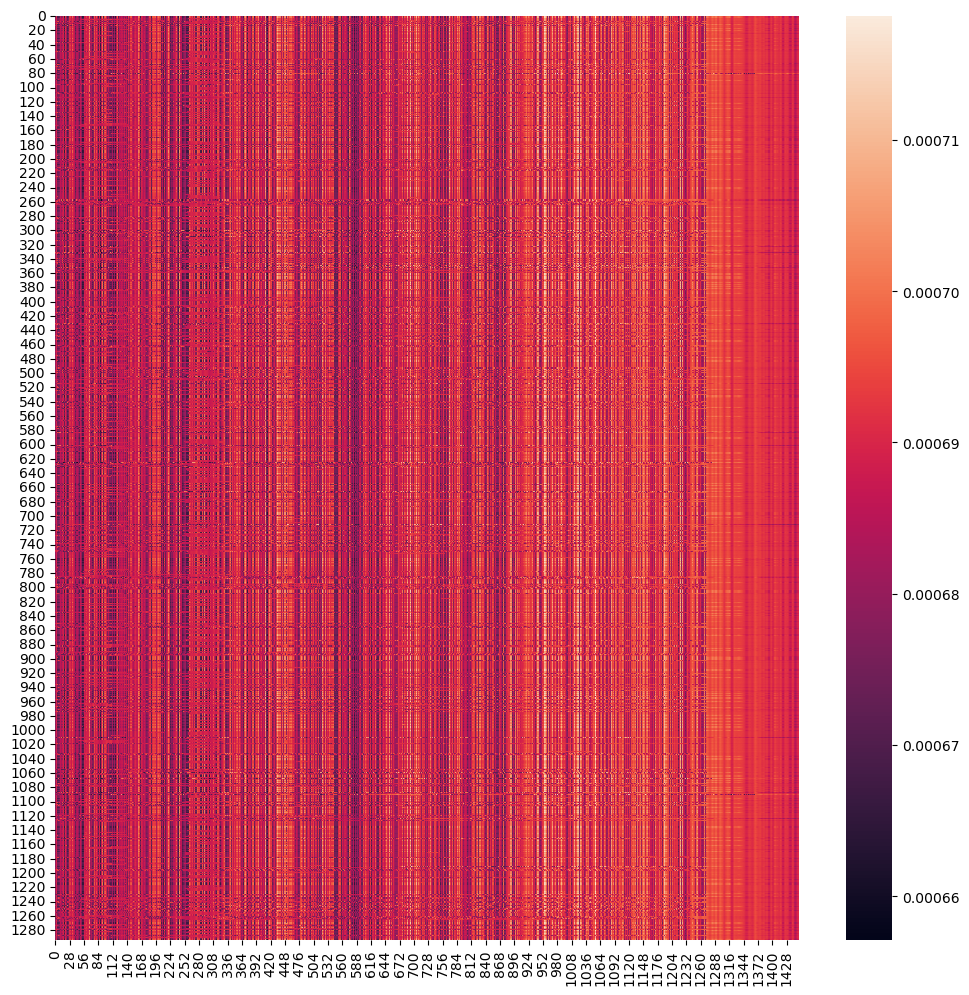

In [94]:
plt.figure(figsize=(12,12))
sns.heatmap(data=true_pred_attn_df)

(1453,)


<AxesSubplot:>

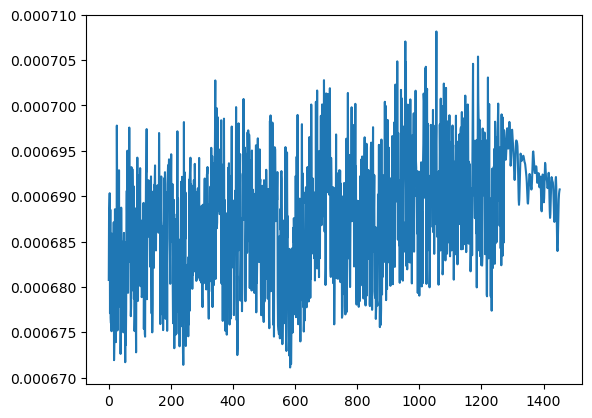

In [95]:
# plt.figure(figsize=(12,12))
print(true_pred_attn_df.mean(axis=0).shape)
sns.lineplot(data=true_pred_attn_df.mean(axis=0))

In [96]:
true_pred_attn_rank_df = true_pred_attn_df.rank("columns", ascending=False).astype(int)
true_pred_attn_rank_df

0     1     2     3     4     5     6     7     8     9     ...  1443  \
0     1168   711   810   528  1355   735  1343  1359  1235  1398  ...   898   
1     1152   823   732   717  1395   699  1377  1385  1329  1406  ...   981   
2     1151   822   730   715  1394   696  1377  1385  1329  1406  ...   980   
3     1169   710   810   527  1356   731  1343  1360  1236  1399  ...   896   
4     1177   817   759   670  1397   691  1374  1387  1283  1412  ...   962   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
1289  1170   711   810   528  1356   731  1344  1361  1237  1399  ...   898   
1290  1182   714   846   529  1362   752  1352  1369  1247  1405  ...   922   
1291  1151   823   731   716  1395   696  1377  1385  1329  1406  ...   980   
1292  1195   801   770   652  1384   714  1367  1379  1272  1407  ...   948   
1293  1152   824   731   717  1396   697  1378  1386  1330  1407  ...   980   

      1444  1445  1446  1447  1448  1449  1450  1451  1452  
0     1007  1026   990   883   743   616   567   543   541  
1     1050  1063  1014   958   888   836   795   761   720  
2     1048  1061  1012   957   885   834   792   759   718  
3     1006  1023   988   882   742   616   568   545   542  
4     1020  1038  1007   947   861   781   724   699   680  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  
1289  1005  1023   988   882   746   617   570   547   545  
1290  1030  1050  1013   900   742   594   538   517   515  
1291  1048  1061  1012   957   886   835   794   760   718  
1292  1011  1022   997   931   837   752   699   682   663  
1293  1049  1062  1013   959   887   836   793   760   719  

[1294 rows x 1453 columns]

<AxesSubplot:>

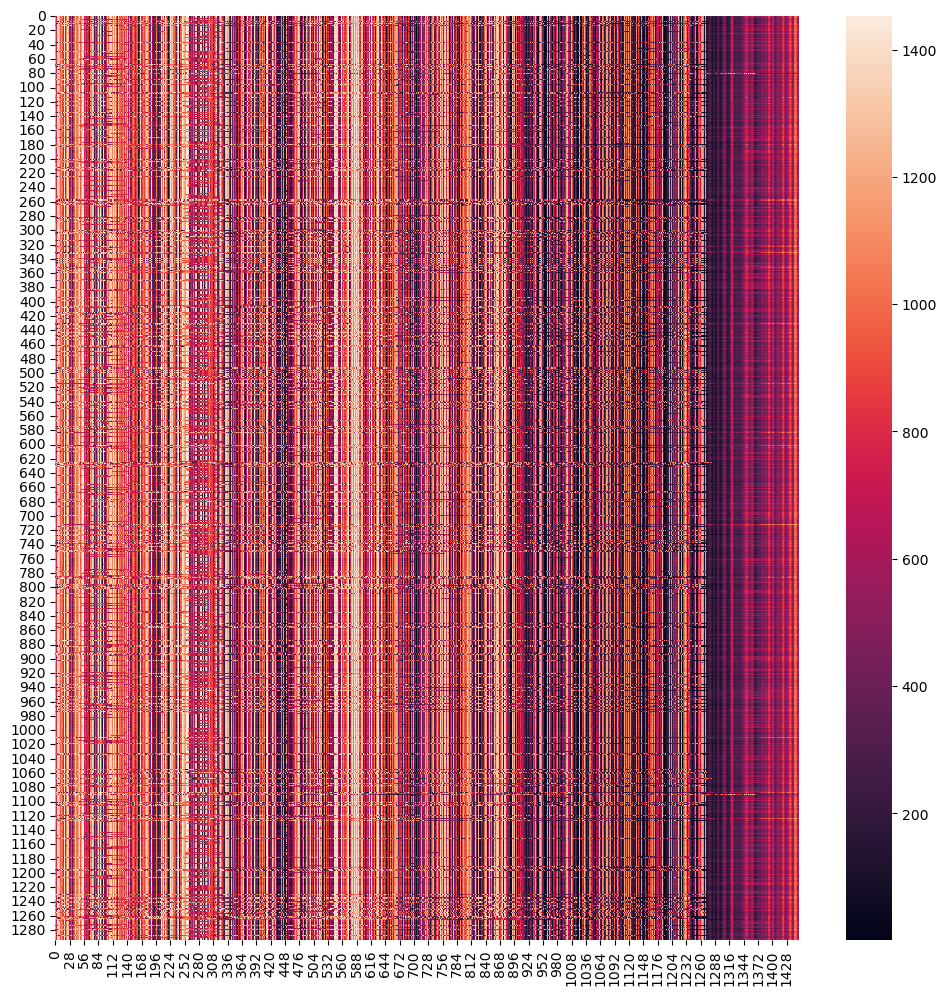

In [97]:
plt.figure(figsize=(12,12))
sns.heatmap(data=true_pred_attn_rank_df)

<AxesSubplot:>

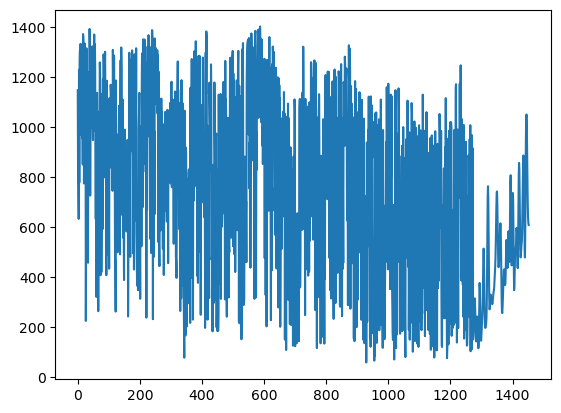

In [98]:
sns.lineplot(data=true_pred_attn_rank_df.mean(axis=0))

In [99]:
# retain only top 10 ranks
true_pred_attn_rank_df[true_pred_attn_rank_df > 10] = None
# drop all columns (positions) with all NaN i.e. this position is not in the top 10 for any sequence
# true_pred_attn_rank_df.dropna(axis=1, how="all", inplace=True)

# drop all columns (positions) with atleast 10% non-NaN values i.e. this position is not in the top 10 for 90% or more of the sequences
# argument 'thresh': Require that many non-NA values.
true_pred_attn_rank_df.dropna(axis=1, how="all", thresh=0.1*true_pred_attn_rank_df.shape[0], inplace=True)

In [100]:
true_pred_attn_rank_df

693   712  929  955  957  1019  1021  1055  1086  1173  1189  1221
0      NaN   NaN  9.0  2.0  5.0   8.0   6.0   1.0  10.0   4.0   3.0   7.0
1      4.0  10.0  6.0  2.0  5.0   9.0   7.0   1.0   NaN   3.0   NaN   NaN
2      4.0   9.0  6.0  2.0  5.0   8.0   7.0   1.0   NaN   3.0   NaN  10.0
3      NaN   NaN  9.0  2.0  5.0   8.0   6.0   1.0  10.0   4.0   3.0   7.0
4      8.0   NaN  6.0  2.0  5.0   9.0   7.0   1.0   NaN   4.0   3.0  10.0
...    ...   ...  ...  ...  ...   ...   ...   ...   ...   ...   ...   ...
1289   NaN   NaN  9.0  2.0  5.0   8.0   6.0   1.0  10.0   4.0   3.0   7.0
1290   NaN   NaN  8.0  2.0  5.0   9.0   6.0   1.0  10.0   4.0   3.0   7.0
1291   4.0   9.0  6.0  2.0  5.0   8.0   7.0   1.0   NaN   3.0   NaN  10.0
1292  10.0   NaN  6.0  2.0  5.0   8.0   7.0   1.0   NaN   4.0   3.0   9.0
1293   4.0   9.0  6.0  2.0  5.0   8.0   7.0   1.0   NaN   3.0   NaN  10.0

[1294 rows x 12 columns]

Int64Index([693, 712, 929, 955, 957, 1019, 1021, 1055, 1086, 1173, 1189, 1221], dtype='int64')


<AxesSubplot:>

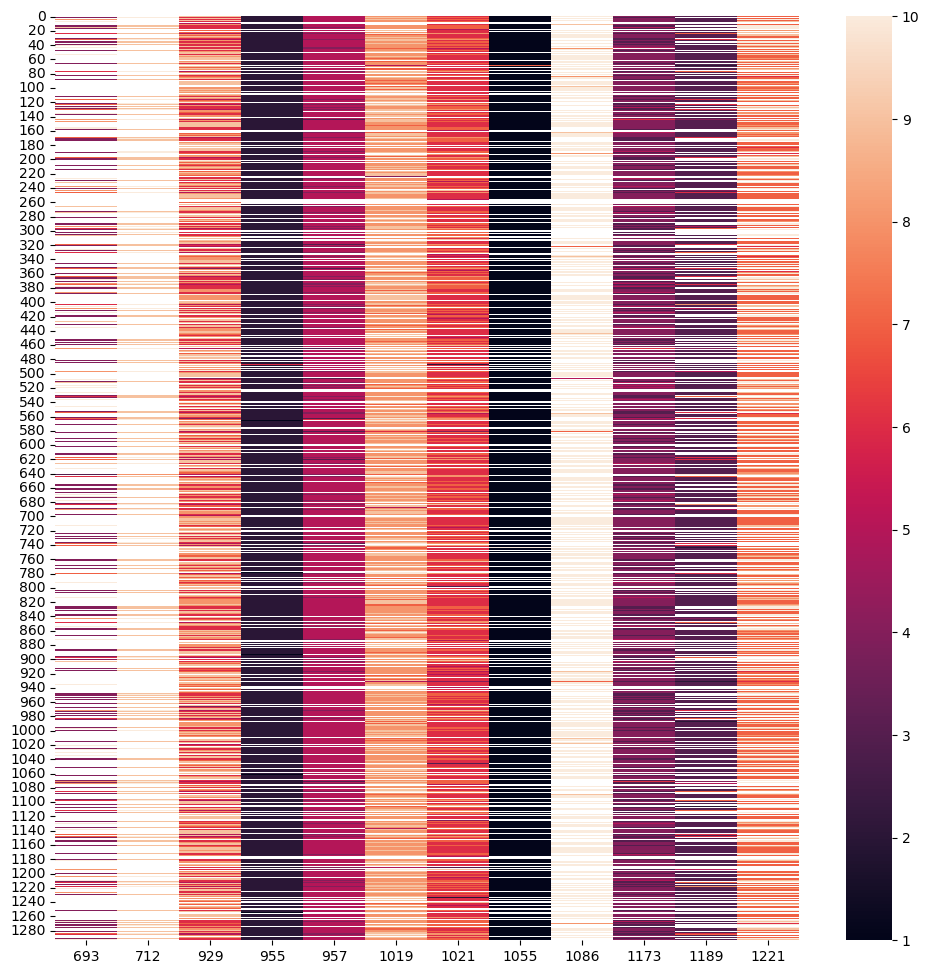

In [101]:
plt.figure(figsize=(12,12))
print(true_pred_attn_rank_df.columns.astype(int))
sns.heatmap(data=true_pred_attn_rank_df)

<AxesSubplot:>

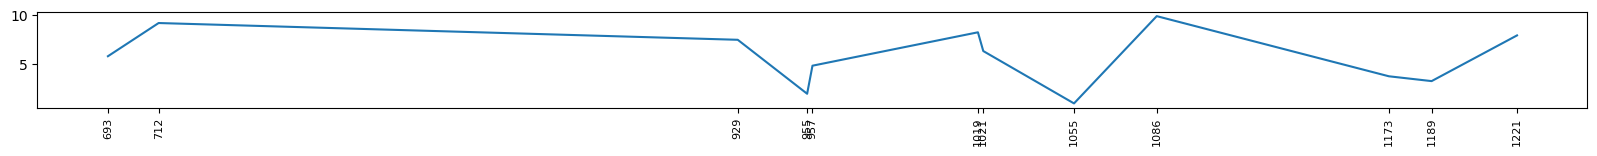

In [102]:
fig = plt.figure(figsize=(20,12))
plt.rcParams["figure.autolayout"] = True
plt.rcParams['xtick.labelsize'] = 8
plt.xticks(rotation=90)
plt.xticks(true_pred_attn_rank_df.columns.astype(int))
fig.subplots_adjust(bottom=0.8)
sns.lineplot(data=true_pred_attn_rank_df.mean(axis=0))